In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d #pre written interpolation function
from scipy.interpolate import griddata

In [2]:
def enum_other_states(n, num_step):
    """enumerate the state. using the following invariants
    (1) symetry (.1,.1,.8) is equivalent to (.1,.1,.8) from firm 1's pespective
    (2) the states must sum to 1"""
    
    states_i = np.arange(0,num_step+1)*(1./num_step)
    if n <=1:
        return states_i.reshape(num_step+1,1)
    else:
        states = []
        states_j = enum_other_states(n-1, num_step)
        for i in states_i:
            for j in states_j:
                if j[0] >= i and (j.sum() + i <= 1):
                    state_ij = np.concatenate( ([i],j) )
                    states.append(state_ij)
        states = np.array(states)
        return  states

In [3]:
class States:
    """class for dealing with the states to ensure
    invariants are kept"""
    
    my_states = None #type nparray
    other_states = None #type np array 2d
    n = 0 #number of players
    num_step = 0 #number of states (states normalized between 0 and 1)
    types = None

    def __init__(self, n, num_step):
        """initialize important class attributes"""
        self.n, self.num_step = n, num_step
      
    
    def gen_states(self):
        """compute all relevant states for firm i (Avoiding side effects)
        the trick is enforcing invariants in the helper"""
        
        new_states = States(self.n, self.num_step)
        other_states =  enum_other_states(self.n-1, self.num_step)
        my_states = 1 - other_states.sum(axis=1)
        
        #initialize the 'type'
        new_states.types = np.tile([0,1],len(my_states))
        new_states.my_states = np.repeat(my_states,2)
        new_states.other_states = np.repeat(other_states,2,axis=0)
        
        return new_states
    
    
    def get_all(self, types=None):
        """return all the market shares, not states though"""
        reshaped_states = self.my_states.reshape((len(self.my_states),1))
        all_states = np.concatenate( (reshaped_states, self.other_states), axis=1 )
        if types == None:
            return all_states
        else:
            return all_states[self.types == types ]
    
    
    def get_all_types(self,types=None):
        """return all the states"""
        reshaped_states = self.my_states.reshape((len(self.my_states),1))
        reshaped_types = self.types.reshape((len(self.types),1))
        all_states = np.concatenate( (reshaped_states, self.other_states,reshaped_types), axis=1 )
        if types == None:
            return all_states
        else:
            return all_states[self.types == types ]
    
    
    def get_len(self):
        return len(self.other_states)
    
    
    def make_states(self, my_states, other_states, types):
        """special initializer for states enforcing the invariants"""
        
        assert np.array(other_states).shape[1] == (self.n -1)
        
        #make a copy to avoid side effects
        new_states = States(self.n, self.num_step)
        
        #combine into 1 array
        other_states = np.sort(other_states)
        my_states = np.array(my_states).reshape((len(my_states),1))
        all_states = np.concatenate((my_states,other_states),axis=1)
        all_states = np.maximum(0, all_states )

        #re-weight states
        denom = all_states.sum(axis=1)
        denom = np.repeat(denom,self.n).reshape(all_states.shape)
        all_states = all_states/denom
        
        #return states
        new_states.types = np.clip(np.array(types).astype(int),0,1)
        new_states.my_states = all_states[:,0]
        new_states.other_states = np.delete(all_states,0,axis=1)
        
        return new_states
    

states = States(3,4).gen_states()

In [4]:
def set_up_env(n, nsim, steps, params):
    """generate reasonable parameters for simulations
    
    theta0 - mean costs; 
    theta1 - returns to scale
    theta2 - collusive markup
    theta3 - collusive markup
    
    we need to have theta0 < theta
    
    theta4 - forgivness probability
    theta5 - size of contracts """
    
    states = States(n, steps).gen_states()
    
    #set up shocks
    var_cost = 1.2/steps
    cost_shocks = np.random.normal(0,var_cost,(nsim,n))
    type_shocks = np.random.binomial(1, params[4], size=(nsim,1))
    
    #set up bids
    bsteps = int(1.1*steps)
    min_bid = params[2] - 2*var_cost
    max_bid = params[0] + params[1] + 3*var_cost
    bid_weighting = (max_bid - min_bid)/(bsteps)
    bids = min_bid + np.arange(1,bsteps)*bid_weighting

    policy = lambda state, shock: 2*state.my_states + params[2]*state.types + shock[:,0]
    value = lambda state: 1 - state.my_states + state.types
    
    return value, policy, bids, states, cost_shocks, type_shocks, params


params =  2.5, -.3, 2., .2, .1, .1, .9 #beta comes lasts
value, policy, bids, states, cost_shocks, type_shocks, params = set_up_env(3, 5, 3, params)
print bids

[1.93333333 2.66666667]


In [5]:
def cost(states, cost_shocks, params):
    """return the cost for all firms based on states"""
    all_types = states.types.reshape((states.get_len(),1))
    all_types = np.tile(all_types, (1,states.n))
    
    c1 = params[0] + params[1]*states.get_all()
    c2 = params[2] + params[3]*states.get_all()
    
    return c1*(1-all_types) + c2*(all_types) + cost_shocks


def weighting(bids):
    """return weighting when there's a tie"""
    n_states, n_players = bids.shape
    low_bid =  np.min(bids,axis=1)
    low_bid = np.repeat(low_bid, n_players).reshape(n_states,n_players)
    
    #winners
    win = (bids <= low_bid)
    n_winners = win.sum(axis=1)*1.
    n_winners = np.repeat(n_winners, n_players).reshape(n_states,n_players)
    
    #add loosers
    lose = (bids > low_bid)
    n_loosers = np.maximum(lose.sum(axis=1)*1.,1.)
    n_loosers = np.repeat(n_loosers, n_players).reshape(n_states,n_players)
    
    return win/(1.*n_winners), lose/(1.*n_loosers)


def profit(bids, states, cost_shocks, params):
    """return firm 0's profit"""
    win_weights, lose_weights = weighting(bids)
    profits = params[5]*win_weights*(bids - cost(states,cost_shocks,params))  
    return profits


def update_state(bids, states, type_shocks, params):
    """update all firms states based on bids
    note: firms in updated states, no longer correspond to their bids"""
    win_weights, lose_weights = weighting(bids)
    new_states = params[5]*win_weights - params[5]*lose_weights + states.get_all()
    new_types = np.maximum(states.types,type_shocks)
    return states.make_states(new_states[:,0],np.delete(new_states,0,axis=1), new_types)


####unit testing######


params =  2.5, -.3, 2., .2, .1, .1, .9 #beta comes lasts
new_states = states.make_states([.5,.5],[[.5,0],[.5,0]],[0,1])
new_shocks = np.array([[0,0,0],[0,0,0]])

print cost(new_states, new_shocks, params)

[[2.35 2.5  2.35]
 [2.1  2.   2.1 ]]


In [6]:
def gen_all_states(bids, states, cost_shocks, type_shocks):
    """tile the states B x NSIM times"""
    
    #join shocks
    type_shocks = type_shocks.reshape(len(type_shocks),1)
    shocks = np.concatenate( (cost_shocks,type_shocks) ,axis=1)
    
    #save lengths for later 
    n_bids, n_shocks = bids.shape[0], shocks.shape[0]
    
    #duplicate states
    all_states = states.get_all_types()
    all_states = np.tile(all_states,(n_bids*n_shocks,1))
    all_states = states.make_states(all_states[:,0],all_states[:,1:-1],all_states[:,-1])
    
    shocks = np.repeat(shocks, states.get_len(), axis=0)
    shocks = np.tile(shocks,(n_bids,1))
    my_bids = np.repeat(bids,states.get_len()*n_shocks)
    
    return my_bids, all_states, shocks[:,:-1], shocks[:,-1]


def gen_all_shocks(states, cost_shocks, type_shocks):
    """do the same thing but return the states and shocks as sepperate objects"""
    n_shocks = cost_shocks.shape[0]
    
    #join shocks
    type_shocks = type_shocks.reshape(n_shocks,1)
    shocks = np.concatenate( (cost_shocks,type_shocks) ,axis=1)

    all_shocks = np.repeat(shocks, states.get_len(), axis=0)
    all_states = np.tile(states.get_all_types(),(n_shocks,1))
    all_states = states.make_states(all_states[:,0],all_states[:,1:-1], all_states[:,-1])
    return all_states, all_shocks[:,:-1], all_shocks[:,-1]

In [7]:
def flip_states(states,i):
    """flip states from perspective of i"""
    other_states = states.get_all()
    i_state = other_states[:,i]
    i_other = np.delete(other_states, i, axis=1)
    other_states = states.make_states(i_state, i_other, states.types)
    return other_states


def calc_bids(policy, states, cost_shocks, start=1):
    """return the other players bids given 
    the state by 'switching perspective' to other firm"""

    other_bids = []
    for i in range(start,states.n):
        other_states = flip_states(states,i)
        i_shocks = cost_shocks.take(np.arange(states.n) + i, mode='wrap', axis=1)
        i_bid = policy(other_states, i_shocks)
        other_bids.append( i_bid )
    
    return np.array(other_bids).transpose()

In [8]:
def policy_operator(init_value, init_policy, bids, states, cost_shocks, type_shocks, params):
    """run a simulatio for just 1 type to recalculate value function
    returns his value from each simulated state"""
    
    n_bids, n_shocks = bids.shape[0], cost_shocks.shape[0]
    
    #generate all bids x sims x states
    my_bids, all_states, all_costs, all_types = gen_all_states( bids, states, cost_shocks,
                                                               type_shocks)
    #other bids in each bid state and concat with my bids
    other_bids = calc_bids(init_policy, all_states, all_costs)
    all_bids = my_bids.reshape(all_states.get_len(),1)
    all_bids = np.concatenate((all_bids,other_bids), axis=1)
    
    #calculate see how the states would update
    next_states = update_state(all_bids, all_states, all_types, params)
    
    #calculate the value of the next state
    value_matrix = profit(all_bids, all_states, all_costs, params)[:,0]
    value_matrix = value_matrix + params[-1]*init_value(next_states)
    
    #set up matrix for policy
    policy_matrix = value_matrix.reshape(n_bids, states.get_len()*n_shocks )
    policy_matrix = np.argmax(policy_matrix ,axis=0)
    policy_matrix = bids[policy_matrix]
    
    all_states, all_costs, all_types = gen_all_shocks(states, cost_shocks, type_shocks)
    all_shocks =  np.concatenate( (all_states.get_all_types(),all_costs), axis=1)
    
    return lambda s0, e0: griddata(all_shocks, policy_matrix, np.concatenate( (s0.get_all_types(),e0), axis=1), method='nearest',rescale=True)

In [46]:
def ic_policy_helper(value, policy, bids, states, cost_shocks, type_shocks, params):
    """return the other players values given 
    the state by 'switching perspective' to other firm"""
    
    #states and shocks different lengths
    all_states, all_costs, all_types = gen_all_shocks(states, cost_shocks, type_shocks)
    bids_step = bids[1] - bids[0]
    all_bids = calc_bids(policy,  all_states, all_costs, start=0) 
    next_states = update_state(all_bids, all_states, all_types, params)
    all_profit = profit(all_bids, all_states, all_costs, params)
    min_bid = all_bids.min(axis=1)
    
    #all states, but with the lower cost function
    dev_states = all_states.make_states(all_states.my_states, all_states.other_states, 
                                        np.ones(all_states.get_len()))
    all_ic = [] #ic constraints for each player
    
    for i in range(0,states.n):

        #figure out collusive profits for i
        col_states = flip_states(all_states,i)
        col_next = flip_states(next_states,i)
        col_profit = all_profit[:,i] + params[-1]*value(col_next)
        
        #evaluate a deviation for i
        dev_bids = all_bids
        dev_bids[:,i] = np.minimum(min_bid - bids_step, bids[0]) #bidder i wins instead
        dev_next = update_state(dev_bids, all_states, all_types, params)
        dev_next.types = dev_next.types*0
        
        #win the auction with the lower costs
        dev_profits = profit(dev_bids, dev_states, all_costs, params)[:,i]
        dev_profits = dev_profits + params[-1]*value(dev_next)
        
        all_ic.append( (col_profit >= dev_profits) )
    
    #generate new policy that is incentive compatible
    all_ic = np.array(all_ic)
    ic = all_ic.min(axis=0)
    
    #update type
    new_types = np.minimum(all_states.types,ic)
    new_states = states.make_states(all_states.my_states,all_states.other_states, new_types)
    
    policy_matrix = policy(new_states, all_costs)
    all_shocks =  np.concatenate( (all_states.get_all_types(), all_costs), axis=1)
    
    policy = lambda s0, e0: griddata(all_shocks, policy_matrix, 
                            np.concatenate( (s0.get_all_types(),e0), axis=1), method='nearest',rescale=True)
    
    return policy, ic
    

def ic_policy_operator(init_value, init_policy, bids, states, cost_shocks, type_shocks, params):
    """given value function, compute incentive compatible policy"""
    
    policy = policy_operator(init_value, init_policy, bids, states, cost_shocks, type_shocks, params)
    ic_policy, ic = ic_policy_helper(init_value, policy, bids, states, cost_shocks, type_shocks, params)
    return ic_policy, ic


params =  2.5, -.3, 2., .2, .1, .1, .9 #beta comes lasts
value, policy, bids, states, cost_shocks, type_shocks, params = set_up_env(3, 5, 3, params)

policy = lambda state, shock: 2*state.my_states + params[2]*state.types + shock[:,0]
value = lambda state: 1 - state.my_states + 5*state.types


policy2, ic = ic_policy_helper(value, policy, bids, states, cost_shocks, type_shocks, params)
print ic

print cost_shocks
print states.get_all()
new_states = states.make_states([.5,.5],[[.5,0],[.5,0]],[0,1])
new_shocks = np.array([[0,0,0],[0,0,0]])

print policy(new_states,new_shocks)

[ True  True  True  True False  True False  True  True  True False  True
  True  True  True  True False  True False  True False  True False  True
  True  True  True  True False  True False  True  True  True False  True
  True  True  True  True False  True False  True False  True False  True
  True  True  True  True False  True False  True False  True False  True]
[[ 0.07155715  0.10141421  0.08057407]
 [ 0.29634153  0.53034345 -0.39493406]
 [-0.16252694 -0.84536926  0.2304035 ]
 [ 0.10214851 -0.11431481  0.27873279]
 [ 0.0732007  -0.07498051 -0.62753103]]
[[1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.66666667 0.         0.33333333]
 [0.66666667 0.         0.33333333]
 [0.33333333 0.         0.66666667]
 [0.33333333 0.         0.66666667]
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.         0.33333333 0.66666667]
 [0.         0.33333333 0.66666667]]
[1. 3

In [47]:
def value_operator(init_value, init_policy, ic, states, cost_shocks, type_shocks, params):
    """given a policy function and some shocks return a value
    function"""
    
    all_states, all_costs, all_types = gen_all_shocks(states, cost_shocks,type_shocks)
    
    all_bids = calc_bids(init_policy,  all_states, all_costs, start=0)
    all_profit = profit(all_bids, all_states, all_costs, params)
    
    #update states that are not ic
    dev_states = states.make_states(all_states.my_states, all_states.other_states,
                                    np.minimum(all_states.types, ic))
    next_states = update_state(all_bids, dev_states, all_types, params)
    
    value_matrix = all_profit[:,0] + params[-1]*init_value(next_states)
    value_matrix = value_matrix.reshape(len(cost_shocks), states.get_len())
    value_matrix = value_matrix.mean(axis=0) #mean over sims
    
    value = lambda s0: griddata(states.get_all_types(), value_matrix, s0.get_all_types(),
                               method='nearest',rescale=True)
    return value, np.amax(value_matrix)


######## unit testing ##########

params =  2.5, -.3, 2., .2, .1, .1, .9 #beta comes lasts
value, policy, bids, states, cost_shocks, type_shocks, params = set_up_env(3, 5, 3, params)

policy = lambda state, shock: 2*state.my_states + params[2]*state.types + shock[:,0]
value = lambda state: 1 - state.my_states + 5*state.types

new_states = states.make_states([.5,.5],[[.5,0],[.5,0]],[0,1])
new_shocks = np.array([[0,0,0],[0,0,0]])
ic = np.ones(60)


print value(new_states)

value, max_val = value_operator(value, policy, ic, states, cost_shocks, type_shocks, params)

print value(new_states)

[0.5 5.5]
[1.42909524 5.12242857]


In [48]:
def operator(init_value, init_policy, bids, states, cost_shocks, type_shocks, params):
    """evaluate states and shocks using look up function"""
    
    policy, ic = ic_policy_operator(init_value, init_policy, bids, states, 
                                       cost_shocks, type_shocks, params)
    
    value, max_value = value_operator(init_value, policy, ic, states, cost_shocks, type_shocks, params)
    
    return max_value, value, policy


###### set up ###### 

params =  2.5, -.3, 2., .2, .1, .1, .9 #beta comes lasts
value, policy, bids, states, cost_shocks, type_shocks, params = set_up_env(3, 5, 3, params)

max_value, value, policy = operator(value, policy, bids, states, cost_shocks, type_shocks, params)
max_value, value, policy = operator(value, policy, bids, states, cost_shocks, type_shocks, params)

new_states = states.make_states([.3,.4],[[.3,.3],[.1,.3]],[0,1])
print policy(new_states,[[0,0,0],[0,0,0]])

[2.66666667 2.66666667]


In [49]:
def  markov_perfect_eq(error, maxiter, init_value, init_policy, bids, states, cost_shocks, type_shocks, param):
    """calculate the value function in a symmetric
        markov perfect equilibria"""
    
    #initialize loop variables
    value_conv = True #don't worry about value function for now
    init_max = -1 #ensure the loop goes once
    value, policy = init_value, init_policy
    
    while  maxiter >= 0 and value_conv :
        
        #iterate loop variables for each player first update value
        max_value, value, p_not = operator(value, policy, bids, states, cost_shocks, type_shocks,  param)
        #then update value
        max_value, v_not, policy = operator(value, policy, bids, states, cost_shocks, type_shocks,  param)    
        #update loop variables
        maxiter = maxiter - 1
        value_conv = np.abs(init_max - max_value) > error
        init_max = max_value
    
    return  value,  policy


#### testing
params =  2.5, -.3, 2., .2, .1, .1, .9 #beta comes lasts
value, policy, bids, states, cost_shocks, type_shocks, params = set_up_env(3, 5, 3, params)

value,  policy = markov_perfect_eq(.01, 10, value, policy, bids, states, cost_shocks, type_shocks, params)

new_states = states.make_states([.3,.4],[[.3,.3],[.1,.3]],[0,1])
print policy(new_states,[[0,0,0],[0,0,0]])

[2.66666667 2.66666667]


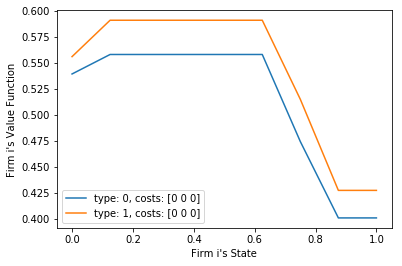

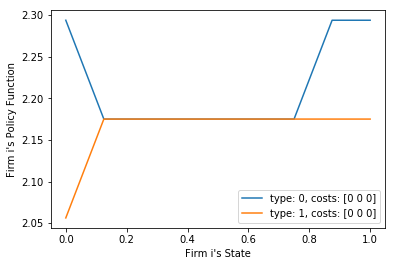

In [51]:
def save_functions(policy, value, states, cost_shocks, type_shocks, 
                   fnames=('funcs/value.csv','funcs/policy.csv')):
    """easily save the points in a policy/value function (so I don't need to re-run code)"""
    
    n, n_states, n_shocks = states.n, states.get_len(), cost_shocks.shape[0] 
    
    #save policy
    all_states, all_costs, all_types = gen_all_shocks(states, cost_shocks, type_shocks)
    all_policy = policy(all_states,all_costs)
    all_policy = all_policy.reshape(all_types.shape[0],1)
    all_types = all_types.reshape(all_types.shape[0],1)
    policy_file = np.concatenate((all_states.get_all_types() , all_costs, all_types, all_policy), axis=1)
    
    policy_meta = np.zeros((1,policy_file.shape[1]))
    policy_meta[0,0:3] = n, n_states, n_shocks
    policy_file = np.concatenate( (policy_meta, policy_file), axis=0)
    np.savetxt(fnames[1], policy_file, delimiter=",")
    
    #save value
    all_value = value(states)
    all_value = all_value.reshape(all_value.shape[0],1)
    value_file = np.concatenate((states.get_all_types(), all_value),axis=1)
    value_meta = policy_meta[:,0:value_file.shape[1]]
    value_file = np.concatenate( (value_meta, value_file), axis=0)
    np.savetxt(fnames[0], value_file, delimiter=",")

    
    
def load_functions(value_name, policy_name):
    """easily save the points in a policy function (so I don't need to re-run code)"""
    
    
    value_file = np.genfromtxt(value_name, delimiter=',')
    n, n_states, n_shocks = value_file[0,0:3] 
    value_file = value_file[1:,:]
    value = lambda s0: griddata(value_file[:,:-1], value_file[:,-1], s0.get_all_types(),
                               method='nearest',rescale=True)
    
    
    policy_file  = np.genfromtxt(policy_name, delimiter=',')
    n, n_states, n_shocks = policy_file[0,0:3]
    policy_file = policy_file[1:,:]
    policy = lambda s0, e0: griddata(policy_file[:,:-2], policy_file[:,-1], 
                            np.concatenate( (s0.get_all_types(),e0), axis=1), method='nearest',rescale=True)
    return value, policy
    
    

value0, policy0 = load_functions('funcs/value.csv', 'funcs/policy.csv')
save_functions(policy0,value0,states,cost_shocks,type_shocks)

policy1, ic1 = ic_policy_helper(value0, policy0, bids, states, cost_shocks, type_shocks, params)
graph_functions(value, policy1, cross_states, cross_shocks, ['Value','Policy'], [0,1])

In [52]:
def gen_cross(states, graph_shocks):
    """gen cross section for purposes of graphing policy"""
    
    my_states = np.arange(0,states.num_step+1)*(1./states.num_step)

    #equalize other market shares
    other_shares = (1 - my_states)/(states.n-1)
    other_states = np.repeat(other_shares, states.n-1 )
    other_states = other_states.reshape(states.num_step + 1 , states.n-1)
    types = np.zeros(states.num_step+1)
    cross_states = states.make_states(my_states,other_states,types)
    
    #then tile shocks based on states
    cross_shocks = []
    for i in range(len( graph_shocks)):
        cross_shock_i = np.tile(  graph_shocks[i], (cross_states.get_len(),1) )
        cross_shocks.append(cross_shock_i)

    return [cross_states]*len(cross_shocks), cross_shocks


def graph_functions(value, policy, cross_states, cross_shocks, labels, types):
    """graph function on predetermined cross section"""
    for l in labels:
        #set up labels
        fig = plt.figure()
        plt.xlabel("Firm i's State")
        plt.ylabel("Firm i's %s Function"%l)
        for t in types:
            for i in range(len(cross_states)):
                #set y based on function
                eval_range = cross_states[i].my_states
                eval_range = cross_states[i].make_states(cross_states[i].my_states, 
                                                         cross_states[i].other_states, 
                                                         cross_states[i].types + t)
                if l=='Value': eval_range =  value(eval_range)
                if l=='Policy': eval_range =  policy(eval_range ,cross_shocks[i])
                new_label = 'type: %s, costs: %s'%(t, cross_shocks[i][0])
                plt.plot( cross_states[i].my_states, eval_range, label=new_label )
            
        plt.legend()
    return

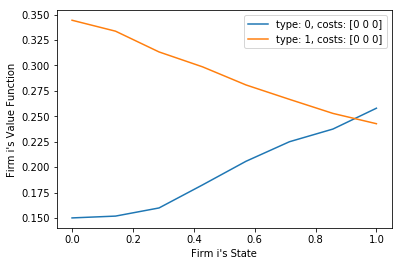

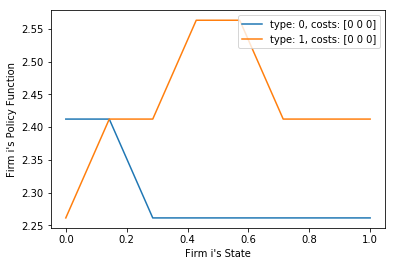

In [69]:
#decreasing returns to scale
#theta0 - mean costs; 
#theta1 - returns to scale;
#theta2 - collusive markup
#theta3 - forgiveness probability
#theta4 - size of contracts

params =  2.5, -.3, 2, .2 , .1, .3, .9 #beta comes lasts
value, policy, bids, states, cost_shocks, type_shocks, params = set_up_env(3, 100, 7, params)

#play with initial policy
value, policy = load_functions('funcs/value.csv', 'funcs/policy.csv')

value,  policy = markov_perfect_eq(.0001, 100, value, policy, bids, states, cost_shocks, type_shocks, params)
save_functions(policy,value,states,cost_shocks,type_shocks)

#generate states for graphing
graph_shocks = np.array([[0,0,0]])
cross_states, cross_shocks = gen_cross(states, graph_shocks)

#roll the operator forward using shocks I intend to graph
policy0, ic = ic_policy_helper(value, policy, bids, states, cost_shocks, type_shocks, params)
graph_functions(value, policy0, cross_states, cross_shocks, ['Value','Policy'], [0,1])

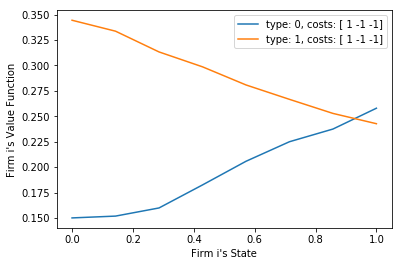

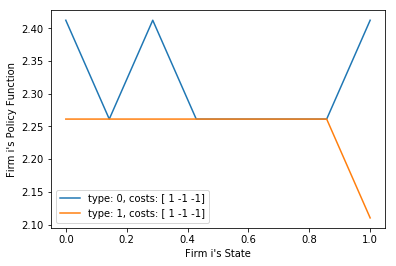

In [70]:
#generate states for graphing
graph_shocks = np.array([[1,-1,-1]])
cross_states, cross_shocks = gen_cross(states, graph_shocks)

#roll the operator forward using shocks I intend to graph
policy, ic = ic_policy_helper(value, policy, bids, states, cost_shocks, type_shocks, params)
graph_functions(value, policy, cross_states, cross_shocks, ['Value','Policy'], [0,1])

In [93]:
init_states = states.make_states([.3,.4],[[.3,.3],[.1,.3]],[0,1])

def follow_path(value, policy, init_state, cost_shocks, type_shocks, params, fname):
    """given value and policy functions, roll forward through the markov process"""
    
    obsv = []
    current_state= init_state
    for i in range(cost_shocks.shape[0]):
        all_bids = calc_bids(policy,  current_state, cost_shocks[i:i+1,:], start=0)
        
        #2 bugs here. states don't udpate right/ types and who won...
        all_profit = profit(all_bids, current_state, cost_shocks[i:i+1,:], params)
        row = np.concatenate((current_state.get_all_types(),all_bids,all_profit,cost_shocks[i:i+1,:],
                              [type_shocks[i]]),axis=1)
        
        
        
        #update loop variable
        obsv.append(row[0,:])
        current_state = update_state(all_bids, current_state, type_shocks[i], params)
        
    
    h1 = 'state,'*states.n+ 'type,'+ 'bid,'*states.n+'profit,'*states.n+'shock,'*states.n+'shock2,'
    
    obsv=np.array(obsv)
    np.savetxt(fname, obsv, delimiter=",", header=h1)
    
    

new_states = states.make_states([.3],[[.3,.3]],[1])
follow_path(value, policy, new_states, cost_shocks, type_shocks, params, 'test.csv')